In [17]:
#importing libraries as needed
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
from glob import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import warnings
warnings.filterwarnings('ignore')
from PIL import Image 
from PIL.ImageDraw import Draw

In [18]:
#Get all images from the dataset, should be 112120
glob_images=glob("/kaggle/input/data/images*/images/*.png")
print('Number of Observations: ', len(glob_images)) # check to make sure I've captured every pathway, should equal 112,120

Number of Observations:  112120


In [19]:
xray_data = pd.read_csv("/kaggle/input/data/Data_Entry_2017.csv")
full_img_paths = {os.path.basename(x): x for x in glob_images}
xray_data['Image Index'] = xray_data['Image Index'].map(full_img_paths.get)
print(xray_data)

                                              Image Index  \
0       /kaggle/input/data/images_001/images/00000001_...   
1       /kaggle/input/data/images_001/images/00000001_...   
2       /kaggle/input/data/images_001/images/00000001_...   
3       /kaggle/input/data/images_001/images/00000002_...   
4       /kaggle/input/data/images_001/images/00000003_...   
...                                                   ...   
112115  /kaggle/input/data/images_012/images/00030801_...   
112116  /kaggle/input/data/images_012/images/00030802_...   
112117  /kaggle/input/data/images_012/images/00030803_...   
112118  /kaggle/input/data/images_012/images/00030804_...   
112119  /kaggle/input/data/images_012/images/00030805_...   

                Finding Labels  Follow-up #  Patient ID  Patient Age  \
0                 Cardiomegaly            0           1           58   
1       Cardiomegaly|Emphysema            1           1           58   
2        Cardiomegaly|Effusion            2        

In [20]:
xray_data = xray_data[["Image Index","Finding Labels"]]

cancer_results=[] 
for i in range(0, len(xray_data)):
    data = xray_data.iloc[i][1]
    if("Mass" in data or "Nodule" in data):
        cancer_results.append(1)
    else:
        cancer_results.append(0)

xray_data["Cancer"] = cancer_results
print(xray_data)

                                              Image Index  \
0       /kaggle/input/data/images_001/images/00000001_...   
1       /kaggle/input/data/images_001/images/00000001_...   
2       /kaggle/input/data/images_001/images/00000001_...   
3       /kaggle/input/data/images_001/images/00000002_...   
4       /kaggle/input/data/images_001/images/00000003_...   
...                                                   ...   
112115  /kaggle/input/data/images_012/images/00030801_...   
112116  /kaggle/input/data/images_012/images/00030802_...   
112117  /kaggle/input/data/images_012/images/00030803_...   
112118  /kaggle/input/data/images_012/images/00030804_...   
112119  /kaggle/input/data/images_012/images/00030805_...   

                Finding Labels  Cancer  
0                 Cardiomegaly       0  
1       Cardiomegaly|Emphysema       0  
2        Cardiomegaly|Effusion       0  
3                   No Finding       0  
4                       Hernia       0  
...                  

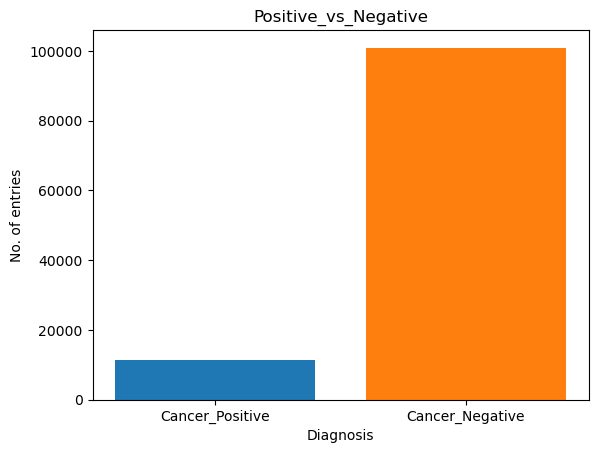

11207


In [21]:
#Plot the distribution
cancer_positive = len(xray_data[xray_data['Cancer'] == 1].index)
cancer_negative = len(xray_data[xray_data['Cancer'] == 0].index)
  
plt.bar('Cancer_Positive' ,cancer_positive, label= 'Positive')
plt.bar('Cancer_Negative' ,cancer_negative, label = 'Negative')
plt.xlabel("Diagnosis")
plt.ylabel("No. of entries")
plt.title("Positive_vs_Negative")
plt.show()
print(cancer_positive)

In [22]:
#Make an even distribution dataframe

# Separate the dataframe into two dataframes based on the value of the index column
cancer_pos = xray_data[xray_data['Cancer'] == 1]
cancer_neg = xray_data[xray_data['Cancer'] == 0]

# Randomly sample the 0 values dataframe to get a subset with the same number of rows as the 1 values dataframe
cancer_neg_sample = cancer_neg.sample(n=len(cancer_pos), random_state=42)  # Adjust random_state for reproducibility

# Concatenate the sampled 0 values dataframe with the original 1 values dataframe
cancer_balanced = pd.concat([cancer_neg_sample, cancer_pos])

# Shuffle the rows of the balanced dataframe (optional)
cancer_balanced = cancer_balanced.sample(frac=1, random_state=42)  # Adjust random_state for reproducibility

# Reset the index of the balanced dataframe if needed
cancer_balanced = cancer_balanced.reset_index(drop=True)
print(cancer_balanced)

                                             Image Index  \
0      /kaggle/input/data/images_009/images/00020850_...   
1      /kaggle/input/data/images_010/images/00022877_...   
2      /kaggle/input/data/images_009/images/00019774_...   
3      /kaggle/input/data/images_004/images/00008473_...   
4      /kaggle/input/data/images_008/images/00016424_...   
...                                                  ...   
22409  /kaggle/input/data/images_002/images/00002701_...   
22410  /kaggle/input/data/images_011/images/00027706_...   
22411  /kaggle/input/data/images_003/images/00005157_...   
22412  /kaggle/input/data/images_011/images/00027542_...   
22413  /kaggle/input/data/images_006/images/00013193_...   

                              Finding Labels  Cancer  
0                                 No Finding       0  
1      Atelectasis|Nodule|Pleural_Thickening       1  
2                                     Nodule       1  
3                                  Emphysema       0  
4   

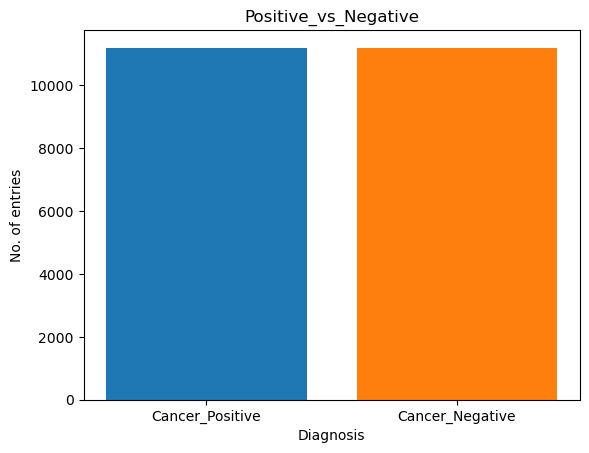

11207


In [23]:
cancer_positive = len(cancer_balanced[cancer_balanced['Cancer'] == 1].index)
cancer_negative = len(cancer_balanced[cancer_balanced['Cancer'] == 0].index)
  
plt.bar('Cancer_Positive' ,cancer_positive, label= 'Positive')
plt.bar('Cancer_Negative' ,cancer_negative, label = 'Negative')
plt.xlabel("Diagnosis")
plt.ylabel("No. of entries")
plt.title("Positive_vs_Negative")
plt.show()
print(cancer_positive)

In [24]:
#Split cancer_balanced so that 80% goes into training, 10% goes into validation, and 10% goes into testing
from sklearn.model_selection import train_test_split
cancer_train, cancer_test = train_test_split(cancer_balanced,test_size=0.15)
cancer_train, cancer_val = train_test_split(cancer_train,test_size=(15/85))
print(f"Length of cancer_train: {len(cancer_train)}")
print(f"Length of cancer_val: {len(cancer_val)}")
print(f"Length of cancer_test: {len(cancer_test)}")


Length of cancer_train: 15689
Length of cancer_val: 3362
Length of cancer_test: 3363


In [25]:
columns = ['Cancer'] 

In [26]:
#preprocessing and splitting of train and test data
Train_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest")
                                    #validation_split=0.1)

#preprocessing of training images
Train_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=cancer_train,
                                                   x_col="Image Index",
                                                   y_col=columns, #can add more categories here
                                                   color_mode="rgb",
                                                   class_mode="raw",
                                                   batch_size=100,
                                                   target_size=(128,128))
                                                   #subset="training")

Found 15689 validated image filenames.


In [27]:
Validation_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest")
                                    #validation_split=0.999)

#preprocessing of validation images
Validation_IMG_Set = Validation_Generator.flow_from_dataframe(dataframe=cancer_val,
                                                   x_col="Image Index",
                                                   y_col=columns,
                                                   color_mode="rgb",
                                                   class_mode="raw",
                                                   batch_size=100,
                                                   target_size=(128,128))
                                                   #subset="validation")

Found 3362 validated image filenames.


In [28]:
Test_Generator = ImageDataGenerator(rescale=1./255)
#preprocessing of testing images
Test_IMG_Set = Test_Generator.flow_from_dataframe(dataframe=cancer_test,
                                                 x_col="Image Index",
                                                 y_col=columns,
                                                 color_mode="rgb",
                                                 class_mode="raw",
                                                 batch_size=100,
                                                 target_size=(128,128))

Found 3363 validated image filenames.


In [29]:
#validating shapes for the model
for data_batch,label_batch in Train_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break
for data_batch,label_batch in Validation_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break
for data_batch,label_batch in Test_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (100, 128, 128, 3)
LABEL SHAPE:  (100, 1)
DATA SHAPE:  (100, 128, 128, 3)
LABEL SHAPE:  (100, 1)
DATA SHAPE:  (100, 128, 128, 3)
LABEL SHAPE:  (100, 1)


In [30]:
# todo: clean imports
from tensorflow.keras.layers import Input, Add, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, MaxPool2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Accuracy, RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

# misc
from tensorflow.keras.applications.resnet import ResNet152
import cv2
from collections import Counter
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [31]:
model = Sequential()
model.add(ResNet152(input_shape=(128, 128, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
#compiling model
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 4, 4, 2048)        58370944  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 58,372,993
Trainable params: 58,221,569
Non-trainable params: 151,424
_________________________________________________________________


In [32]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("resnet152Kaggle1Output.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto', start_from_epoch=2)
#training the model
history = model.fit(Train_IMG_Set,
                      validation_data=Validation_IMG_Set,
                      epochs=40)

Epoch 1/40
157/157 [==============================] - 658s 3s/step - loss: 1.4140 - accuracy: 0.5046 - val_loss: 0.6942 - val_accuracy: 0.4872
Epoch 2/40
157/157 [==============================] - 528s 3s/step - loss: 1.1140 - accuracy: 0.5048 - val_loss: 0.6933 - val_accuracy: 0.4872
Epoch 3/40
157/157 [==============================] - 521s 3s/step - loss: 1.0313 - accuracy: 0.5056 - val_loss: 0.6933 - val_accuracy: 0.4872
Epoch 4/40
157/157 [==============================] - 506s 3s/step - loss: 0.9811 - accuracy: 0.5063 - val_loss: 0.6934 - val_accuracy: 0.4872
Epoch 5/40
157/157 [==============================] - 527s 3s/step - loss: 0.9631 - accuracy: 0.5100 - val_loss: 0.6935 - val_accuracy: 0.4872
Epoch 6/40
157/157 [==============================] - 530s 3s/step - loss: 0.9251 - accuracy: 0.5062 - val_loss: 0.6934 - val_accuracy: 0.4872
Epoch 7/40
157/157 [==============================] - 511s 3s/step - loss: 0.9086 - accuracy: 0.5018 - val_loss: 0.6933 - val_accuracy: 0.4872

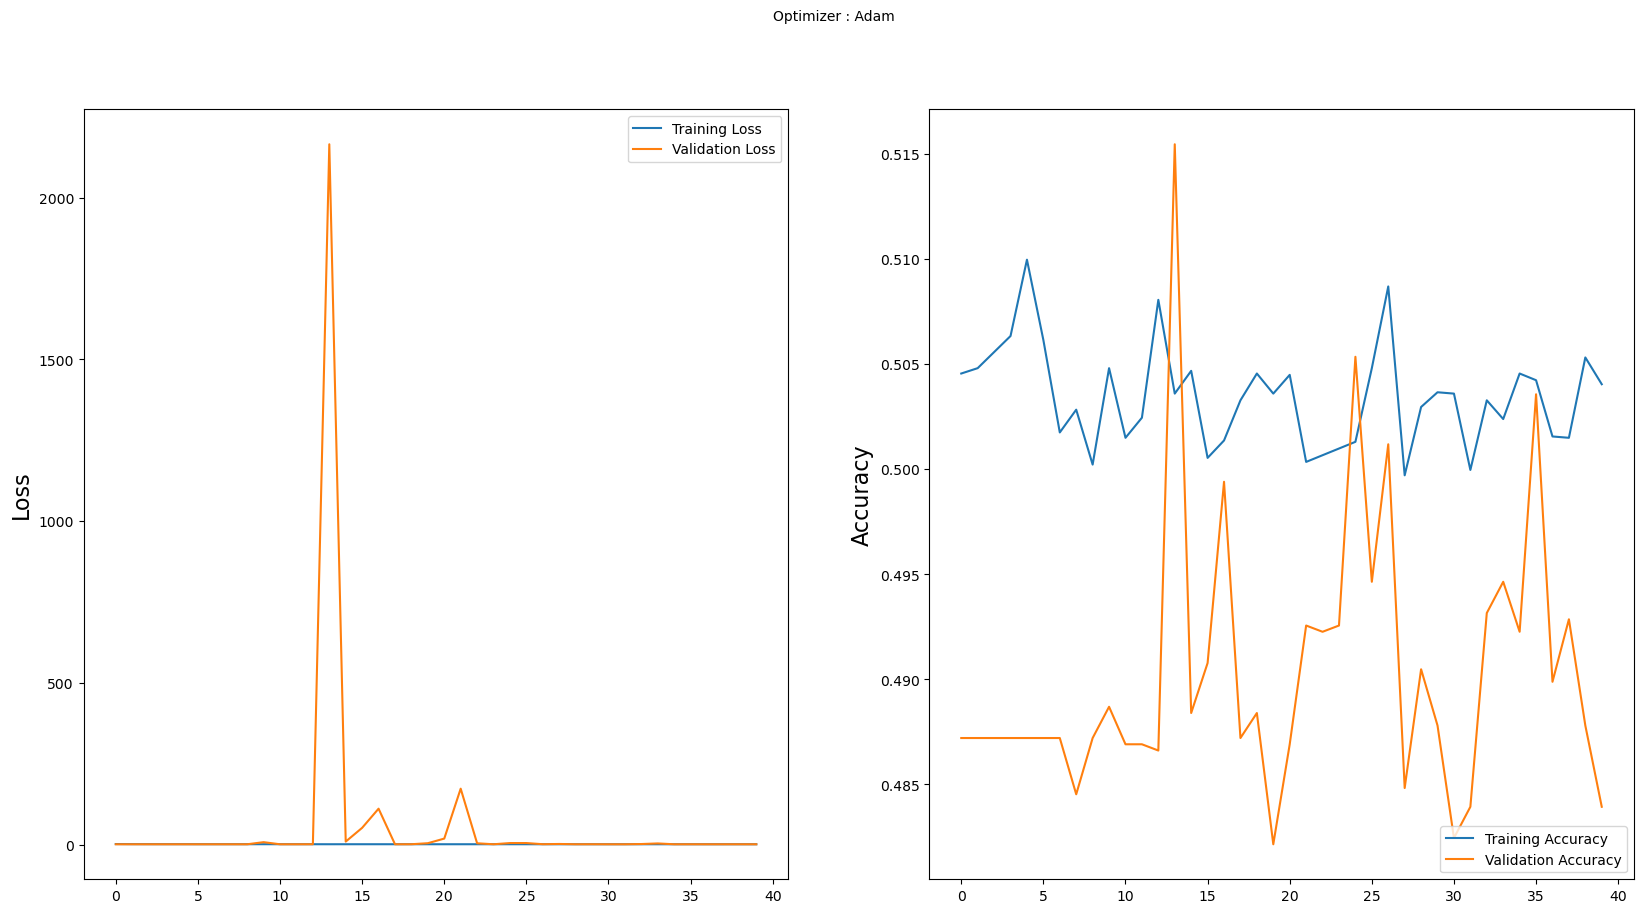

In [33]:
#plotting accuracy and loss
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [34]:
model.save("resnet152Kaggle1Output.h5")

In [35]:
#testing results
results = model.evaluate(Test_IMG_Set)
preds   = model.predict(Test_IMG_Set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100,2)))

34/34 [==============================] - 79s 2s/step
The current model achieved a categorical accuracy of 49.33%!


In [36]:
import math
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve

test_batches = Test_Generator.flow_from_dataframe(dataframe = cancer_test, x_col="Image Index", y_col="Cancer", class_mode="raw", batch_size=100)

# predict the probability distribution of the data
predictions=model.predict_generator(test_batches, verbose=1)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

number_of_examples = len(Test_IMG_Set.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 100))

# 1.0 above is to skip integer division
For_Prediction_Class = []
for i in range(0,int(number_of_generator_calls)):
    For_Prediction_Class.extend(np.array(test_batches[i][1]))

print(classification_report(For_Prediction_Class,y_pred))

Found 3363 validated image filenames.
34/34 [==============================] - 80s 2s/step
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1656
           1       0.00      0.00      0.00      1707

    accuracy                           0.49      3363
   macro avg       0.25      0.50      0.33      3363
weighted avg       0.24      0.49      0.32      3363

